# 5. Feature Engineering

Original features may not fully capture the underlying relationships in the data. By creating new features, we aim to capture more complex relationships and interactions between variables that are not evident in the original data. This allows the model to better understand the underlying patterns in the data and make more accurate predictions.

In the following sections, we will create a few sets of features based on the original ones. We will then gain insights into their importance using visualization.

## Import Libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from imblearn.under_sampling import RandomUnderSampler

In [138]:
from Utils import plot_corrlation_heatmap, plot_mi_heatmap

## Import Train and Test Datasets

In [2]:
y_train = pd.read_csv('Data/y_train.csv')
X_train = pd.read_csv('Data/X_train.csv')
y_test = pd.read_csv('Data/y_test.csv')
X_test = pd.read_csv('Data/X_test.csv')

In [73]:
X_train.columns

Index(['type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4',
       'room_type_reserved_room_type 5', 'room_type_reserved_room_type 6',
       'room_type_reserved_room_type 7', 'market_segment_type_aviation',
       'market_segment_type_complementary', 'market_segment_type_corporate',
       'market_segment_type_offline', 'market_segment_type_online',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'required_car_parking_space', 'repeated_guest', 'no_of_adults_scaled',
       'no_of_children_scaled', 'no_of_weekend_nights_scaled',
       'no

## Define Helper Functions for Visualization

In [3]:
def custom_KDE(x_column_name):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))
    # Plot the kernel density estimate (KDE) for each group
    sns.kdeplot(data=pd.concat([X_train, y_train], axis=1), x=x_column_name, hue='booking_status', ax=ax, fill=True)
    # Set the title
    ax.set_title(f'Relationship between {x_column_name} and Booking Status')
    # Show the plot
    plt.show()
    
def custom_heatmap(x_column_name):
    crosstab = pd.crosstab(pd.concat([X_train, y_train], axis=1)['booking_status'], pd.concat([X_train, y_train], axis=1)[x_column_name])
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt='g')
    # Set the title
    plt.title(f'Relationship between Booking Status and {x_column_name}')
    # Show the plot
    plt.show()

def custom_displot(x_column_name):
    # Plot the distribution for each group
    sns.displot(data=pd.concat([X_train, y_train], axis=1), x=x_column_name, hue='booking_status', discrete=True, height=4, aspect=1.5)
    # Set the title
    plt.title(f'Relationship between {x_column_name} and Booking Status')
    # Show the plot
    plt.show()

## Feature Engineering on Number of Customers

There are several ways to capture the relationship between no_of_adults and no_of_children:

1. **Sum of the Two Variables**: This feature represents the total number of customers.
2. **Solo Traveler Indicator**: This feature indicates whether the customer is a solo traveler (only one adult or one child).
3. **Customer Type Categories**: This feature categorizes customers into "Adults Only", "Children Only", and "Mixed Group" based on the combination of adults and children.
4. **Percentage of Adults**: This feature calculates the percentage of adults in the booking (number of adults / total number of customers).

We will create features with all the possible methods and visualize the resulted variables.

In [75]:
# this function will be used to create customers number related features
def process_customer_number(df):
    df["no_of_customers"] = df['no_of_adults'] + df['no_of_children']
    df["solo_traveller"] = ((df["no_of_adults"]==1) & (df["no_of_children"]==0)) | ((df["no_of_adults"]==0) & (df["no_of_children"]==1))
    df['perc_adults'] = df['no_of_adults']/df["no_of_customers"]
    
    def get_traveller_type(x):
        if (x["no_of_adults"]>0) & (x["no_of_children"]==0):
            return 'adults_only'
        elif (x["no_of_adults"]==0) & (x["no_of_children"]>0):
            return 'children_only'
        else:
            return 'mixed'
    df["traveller_type"] = df.apply(get_traveller_type, axis=1)

In [76]:
process_customer_number(X_train)
process_customer_number(X_test)

In [77]:
customer_number_cols = ["no_of_customers", "perc_adults", "solo_traveller", "traveller_type"]

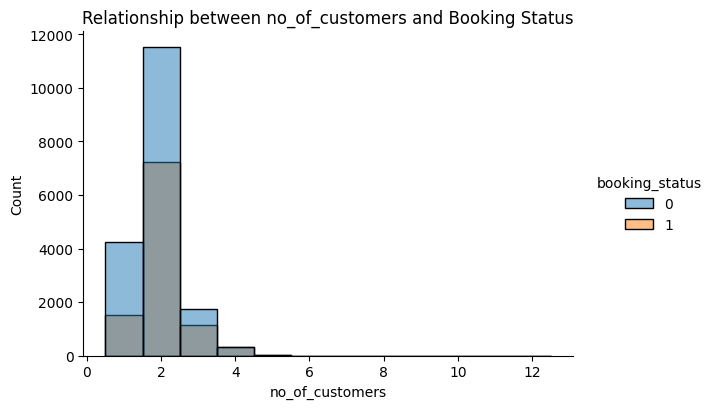

In [78]:
custom_displot(customer_number_cols[0])

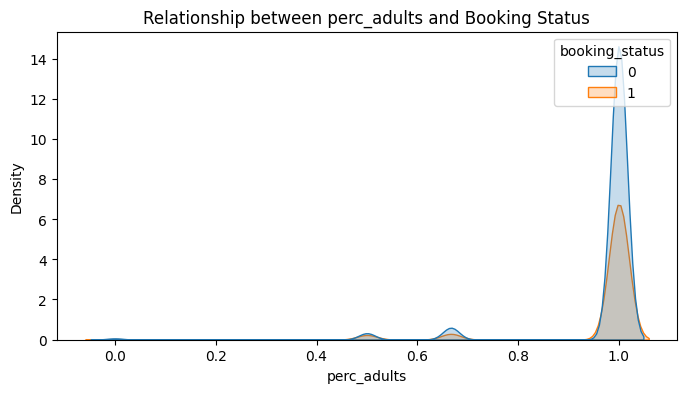

In [79]:
custom_KDE(customer_number_cols[1])

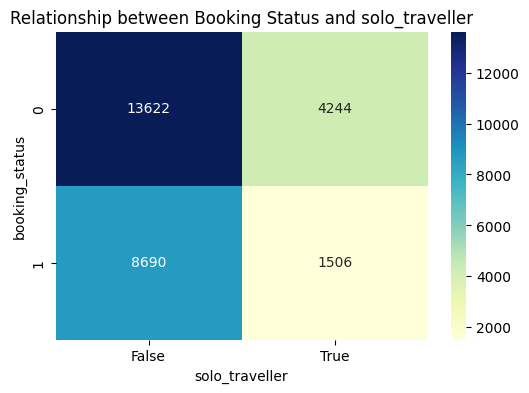

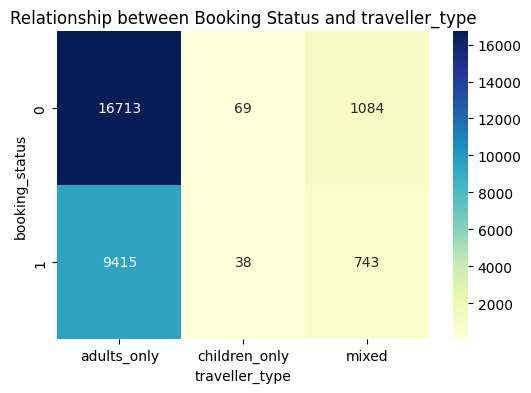

In [80]:
for col in customer_number_cols[2:]:
    custom_heatmap(col)

Several insights can be gained from the visualization:

1. **Solo Traveler Trend**: The data indicates that solo travelers exhibit a lower cancellation rate. This observation may be attributed to their greater autonomy over their schedules, reducing the likelihood of encountering conflicts that could lead to cancellations.
2. **Adult-Only Groups vs. Mixed Groups**: The majority of traveler groups consist solely of adults, and these bookings tend to exhibit a lower cancellation rate compared to bookings including children. This suggests that adult-only groups may experience fewer disruptions or logistical challenges, leading to a higher likelihood of following through with their reservations.

## Feature Engineering on Number of Nights

There are several ways to capture the relationship between no_of_weekend_nights and no_of_week_nights:

1. **Sum of Nights**: One approach is to add the number of weekend nights and weeknights to calculate the total number of nights stayed, providing a comprehensive view of the overall duration of the stay.
2. **Customer Type Categories**: Another method involves categorizing customers based on their booking patterns. This categorization includes "Hour Room" bookings, which may span a short duration during the day, "Weekend Only" bookings for leisure trips, "Weekday Only" bookings typically associated with business trips, and bookings with a mix of both weekdays and weekends.
3. **Percentage of Weekday Nights**: This method calculates the proportion of weeknight stays in relation to the total number of nights stayed. It provides insight into the distribution of stays across weekdays and weekends, helping identify any weekday preference or bias in booking behavior.

We will create features with all the possible methods and visualize the resulted variables.

In [4]:
# this function will be used to create nights number related features
def process_nights_number(df):
    df["no_of_nights"] = df['no_of_weekend_nights'] + df['no_of_week_nights']
    df["perc_weekday_nights"] = df['no_of_weekend_nights']/df["no_of_nights"]
    
    def get_stay_type(x):
        if (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]==0):
            return 'hour_room'
        elif (x["no_of_weekend_nights"]>0) & (x["no_of_week_nights"]==0):
            return 'weekend_only'
        elif (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]>0):
            return 'weekday_only'
        else:
            return 'mixed'
    df["stay_type"] = df.apply(get_stay_type, axis=1)

    # replace nan with 0
    df["perc_weekday_nights"] = df["perc_weekday_nights"].apply(lambda x: 0 if math.isnan(x) else x)

In [7]:
process_nights_number(X_train)
process_nights_number(X_test)

In [5]:
nights_number_cols = ["no_of_nights",  "stay_type", "perc_weekday_nights"]

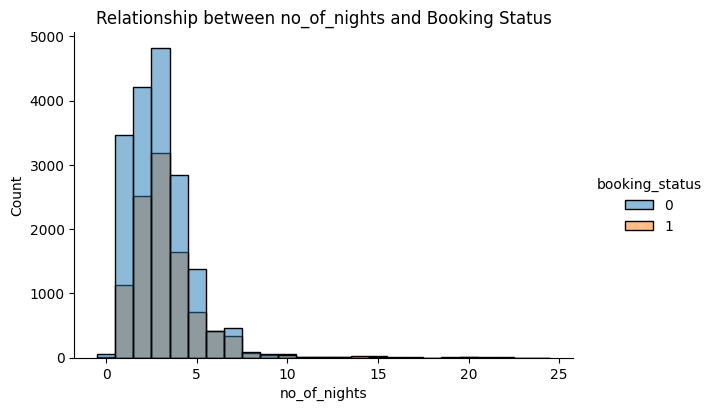

In [84]:
custom_displot(nights_number_cols[0])

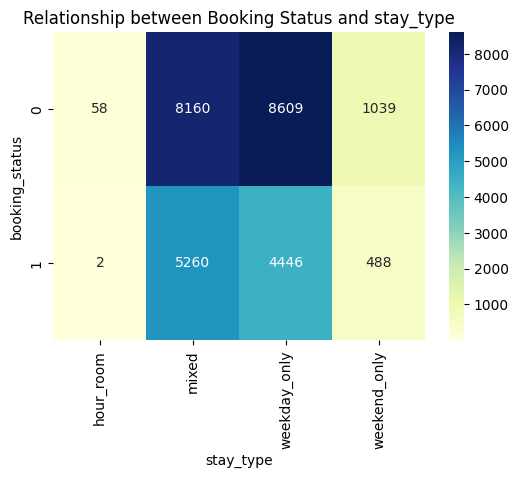

In [85]:
custom_heatmap(nights_number_cols[1])

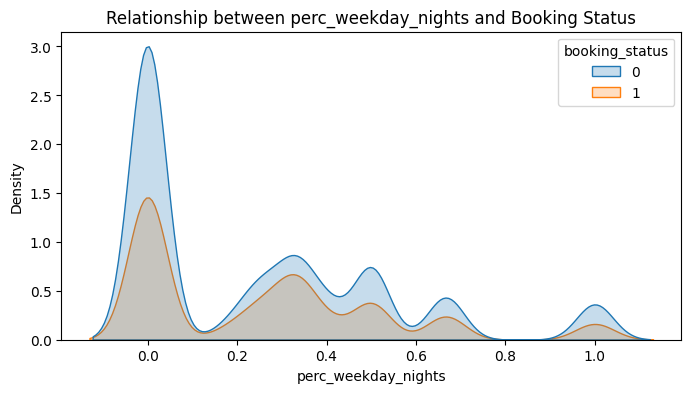

In [9]:
custom_KDE(nights_number_cols[2])

Several insights can be gained from the visualization:

1. **Total Nights Stayed and Cancellation Rates**: The data suggests a correlation between the total number of nights stayed and cancellation rates, particularly evident when exceeding 5 nights. As the duration of the stay increases, cancellation rates tend to rise, pointing to a potential trend where longer stays are associated with a higher likelihood of cancellations.
2. **Weekday-Only Stay Type**: Bookings categorized as "Weekday Only" display a relatively lower cancellation rate. This trend is likely attributed to the nature of such trips, where customers typically plan in advance, such as applying for leave, and are less inclined to make changes to their reservations.
3. **Percentage of Weekday Nights and Cancellation Rates**: An intriguing observation emerges when analyzing the percentage of weekday nights within the total stay duration. Specifically, when the proportion of weekday nights falls within the range of 0.2 to 0.4, there is a notable increase in cancellation rates. This suggests that bookings with a balanced mix of weekday and weekend nights may be associated with a higher likelihood of cancellations, warranting further investigation into the underlying factors driving this trend.

## Feature Engineering on Previous Bookings

There are several ways to capture the relationship between no_of_previous_cancellations and no_of_previous_bookings_not_canceled:

1. **Total Number of Previous Bookings**: One approach is to add the number of previous cancellations and the number of previous successful stays to calculate the total number of previous bookings. This provides a comprehensive view of the customer's booking history.
2. **Cancellation Rate Based on Previous Bookings**: Another method involves calculating the cancellation rate based on the customer's previous bookings. This is done by dividing the number of cancellations by the total number of previous bookings, providing insight into the customer's historical cancellation behavior.
3. **Cancellation Type Categories**: A third method categorizes customers based on their cancellation history. This categorization includes customers with "No Previous Booking," indicating first-time bookers, "Never Cancelled Before," indicating customers who have never canceled a booking, "All Previous Bookings are Cancelled," indicating customers with a history of only cancellations, and "Mix of Cancelled and Successful Stay," indicating customers with a combination of canceled and successful bookings.

We will create features with all the possible methods and visualize the resulted variables.

In [86]:
# this function will be used to create previous bookings related features
def process_previous_booking(df):
    df["no_of_previous_bookings"] = df['no_of_previous_cancellations'] + df['no_of_previous_bookings_not_canceled']
    df["previous_cancellation_rate"] = df.apply(lambda x: 0 if x["no_of_previous_bookings"]==0 else x['no_of_previous_cancellations']/x["no_of_previous_bookings"], axis=1)
    
    def get_cancellation_type(x):
        if (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'no_booking'
        elif (x["no_of_previous_cancellations"]>0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'all_cancelled'
        elif (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]>0):
            return 'all_successful'
        else:
            return 'mixed'
    df["cancellation_type"] = df.apply(get_cancellation_type, axis=1)

In [87]:
process_previous_booking(X_train)
process_previous_booking(X_test)

In [88]:
previous_booking_cols = ["no_of_previous_bookings", "previous_cancellation_rate", "cancellation_type"]

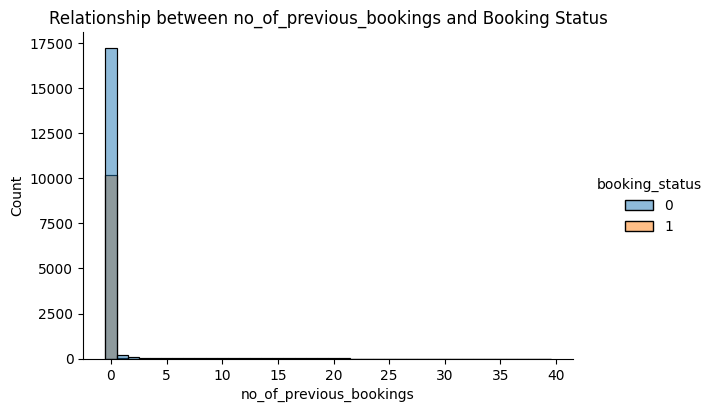

In [89]:
custom_displot(previous_booking_cols[0])

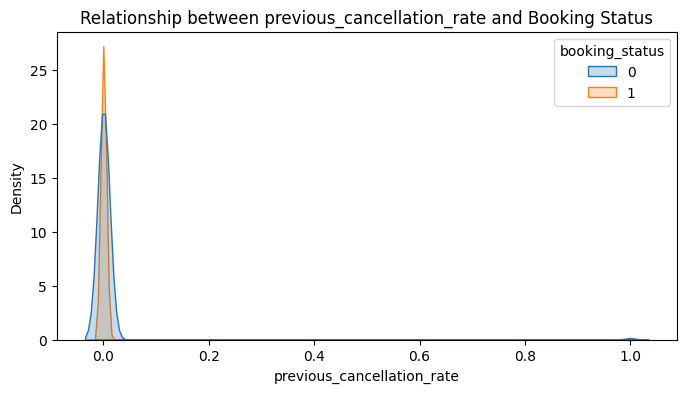

In [90]:
custom_KDE(previous_booking_cols[1])

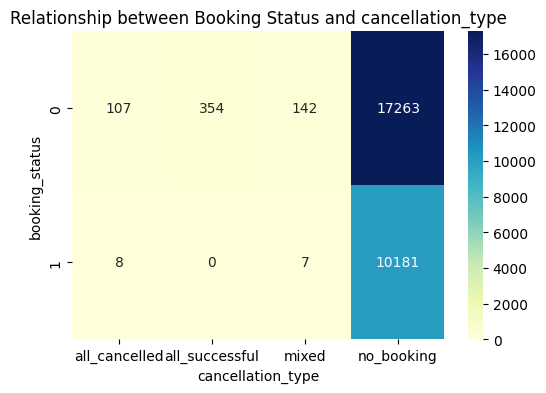

In [91]:
custom_heatmap(previous_booking_cols[2])

Insights below can be gained from the visualization:

**Effect of Previous Bookings on Cancellation Rates**: Analysis reveals that customers with previous bookings, regardless of whether they were canceled or not, tend to exhibit lower cancellation rates. This suggests a potential trend where customers with prior experience with the hotel are more committed to their bookings. However, it's noteworthy that a significant portion of customers do not have any previous bookings, as indicated by the "repeated_guest" column. This indicates that the majority of customers are first-time bookers, highlighting the importance of understanding their behavior and preferences to effectively manage reservation cancellations.

## Feature Engineering on Continuous Variables

"lead_time" and "avg_price_per_room" are two numerical variables with a significant number of unique values. To enhance interpretability and capture additional information, we can categorize them through binning. This process involves dividing the range of values into discrete intervals or bins, allowing us to analyze the data in a more structured and informative manner.

In [92]:
# this function will be used to bin numerical features
def process_numerical(df):
    def binning(x):
        if x<=50:
            return '0 to 50'
        elif x<=100:
            return '50 to 100'
        elif x<=150:
            return '100 to 150'
        elif x<=200:
            return '150 to 200'
        elif x<=300:
            return '200 to 300'
        else:
            return 'greater than 300'
    # lead_time
    df['lead_time_cat'] = df['lead_time'].apply(binning)

    # avg_price_per_room
    df['avg_price_per_room_cat'] = df['avg_price_per_room'].apply(binning)

In [93]:
process_numerical(X_train)
process_numerical(X_test)

In [94]:
binned_numerical_cols = ["lead_time_cat", "avg_price_per_room_cat"]

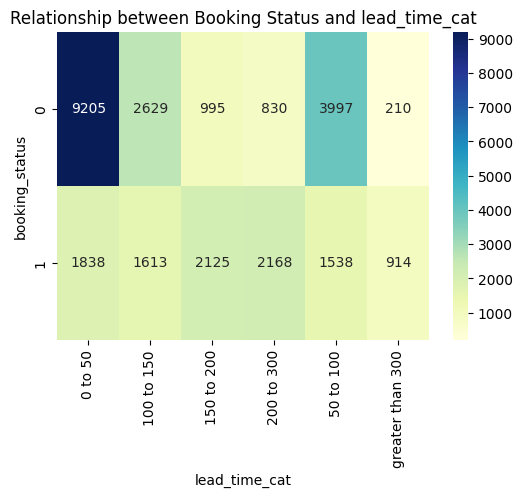

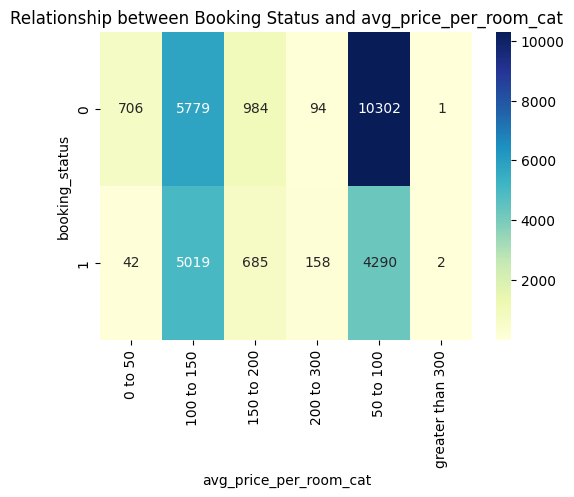

In [95]:
for col in binned_numerical_cols:
    custom_heatmap(col)

Clear differences in cancellation behavior are evident across various groups. For instance, bookings with lead times between 0 and 50 exhibit fewer cancellations, whereas those with lead times between 150 and 300 demonstrate markedly higher cancellation rates. Similarly, bookings for rooms priced below 50 euros tend to have lower cancellation rates, whereas cancellations become more prevalent for rooms with higher prices.

## Feature Engineering on Special Requests

We can process the 'no_of_special_requests' column by creating a binary variable that indicates whether any special requests were made or not.

In [96]:
# this function will be used to process special requests
def process_requests(df):
    df['have_special_requests'] = df['no_of_special_requests'].apply(lambda x: 0 if x==0 else 1)

In [97]:
process_requests(X_train)
process_requests(X_test)

In [98]:
requests_col = ['have_special_requests']

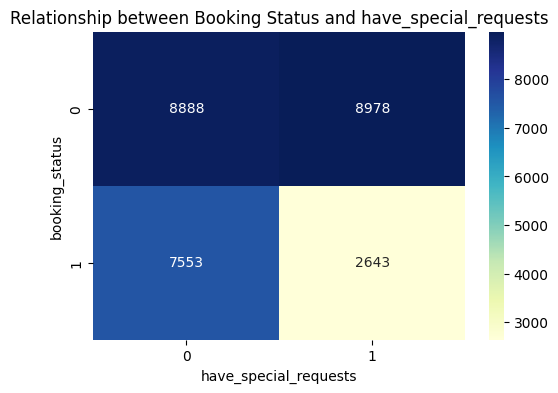

In [99]:
custom_heatmap(requests_col[0])

The data suggests that customers who make special requests are less likely to cancel their bookings. This trend may be attributed to their heightened level of trip planning and preparation.

## Feature Engineering on Price

These features may be related to room price: avg_price_per_room, type_of_meal_plan, room_type_reserved, market_segment_type, and their relationships are visualized below.

In [3]:
X_train[X_train['avg_price_per_room']==0]

,type_of_meal_plan_meal plan 1,type_of_meal_plan_meal plan 2,type_of_meal_plan_meal plan 3,type_of_meal_plan_not selected,room_type_reserved_room_type 1,room_type_reserved_room_type 2,room_type_reserved_room_type 3,room_type_reserved_room_type 4,room_type_reserved_room_type 5,room_type_reserved_room_type 6,...,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
47,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,2,2017,9,10,complementary,0,0,0.0,1
114,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,13,2018,6,1,complementary,3,5,0.0,1
165,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,4,2018,2,27,complementary,0,0,0.0,1
212,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,1,2017,8,12,complementary,0,1,0.0,1
213,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,4,2017,8,23,complementary,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27834,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,room_type 7,0,2018,6,7,complementary,4,17,0.0,1
27913,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,room_type 7,0,2018,3,21,complementary,3,15,0.0,1
27939,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,room_type 1,1,2018,3,2,online,0,0,0.0,0
28016,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,room_type 2,3,2017,8,9,online,0,0,0.0,2


Bookings with avg_price_per_room=0 could be because the customers received some special promotion.

As including observations with avg_price_per_room=0 will greatly impact the average room price of different groups, we will exclude these observations from the following visualization.

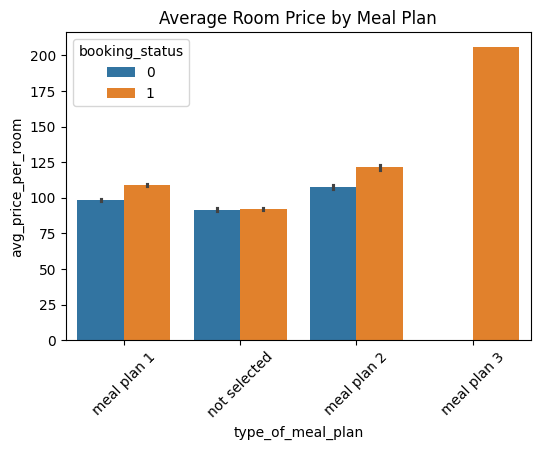

In [4]:
plt.figure(figsize=(6, 4))
sns.barplot(x='type_of_meal_plan', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Meal Plan')
plt.xticks(rotation=45)
plt.show()

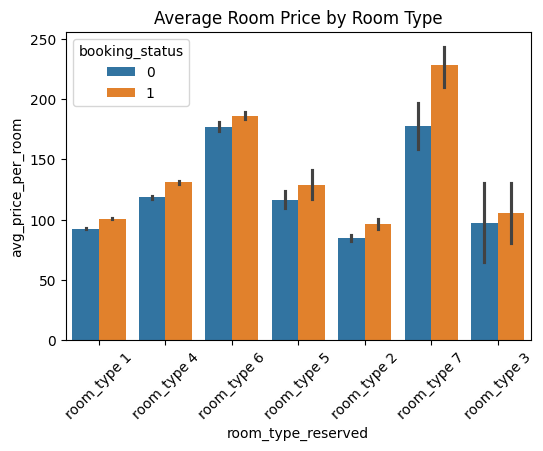

In [5]:
plt.figure(figsize=(6, 4))
sns.barplot(x='room_type_reserved', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Room Type')
plt.xticks(rotation=45)
plt.show()

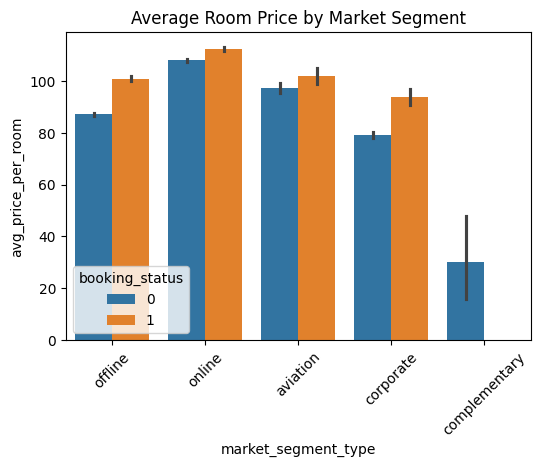

In [6]:
plt.figure(figsize=(6, 4))
sns.barplot(x='market_segment_type', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Market Segment')
plt.xticks(rotation=45)
plt.show()

Although there are more similarities in price within categories of meal plans and room types compared to differences between categories, no significant distinctions are observed between canceled and non-canceled bookings. This suggests that these features may not be informative for predicting cancellations.

## Feature Engineering on Dates

By leveraging the arrival date and lead time, we can calculate the booking date. To enhance the granularity of our date features, we will extract various components such as the year, quarter, season, month, week, day of the week, day of the year, and whether it is a weekend.

In [7]:
# helper function for deriving season from month
def get_season_type(x):
    if (x == 12 or x == 1 or x == 2):
        return "spring"
    elif (x >= 3 and x <=5):
        return "summer"
    elif (x >= 6 and x <=8):
        return "autumn"
    else:
        return "winter"

In [11]:
# this function will be used to create arrival date related features
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })
        
    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    df['arrival_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    df['arrival_season'] = df['arrival_month'].apply(get_season_type)
    
    df.drop(columns='date', inplace=True)

In [18]:
# this function will be used to create booking date related features
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day
    df['booking_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    df['booking_season'] = df['booking_month'].apply(get_season_type)

In [19]:
# call the helper functions
process_arrival_date(X_train)
process_booking_date(X_train)

process_arrival_date(X_test)
process_booking_date(X_test)

In [13]:
# this function will be used to plot the number of cancelled bookings
def plot_dots_ordinal(feature, ax):
    dots = pd.concat([X_train, y_train], axis=1).groupby(feature)['booking_status'].sum().reset_index()
    dots.sort_values(feature, inplace=True)
    train_containers = ax.containers[0]
    
    containers = [train_containers]
    
    for container in containers:
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots.booking_status
        x_s = x_s[:y_s.shape[0]]
        ax.plot(x_s, y_s, marker='.', alpha=0.8, markersize=10)

Barplots are used to show the total number of booking, and lines show the number of canceled bookings.

In [14]:
arrival_columns = ['arrival_year', 'arrival_quarter', 'arrival_season', 'arrival_month', 'arrival_dayofweek', 
           'arrival_date', 'arrival_week', 'arrival_dayofyear', 'arrival_isweekend']
n_cols = 3
n_rows = math.ceil(len(arrival_columns)/n_cols)

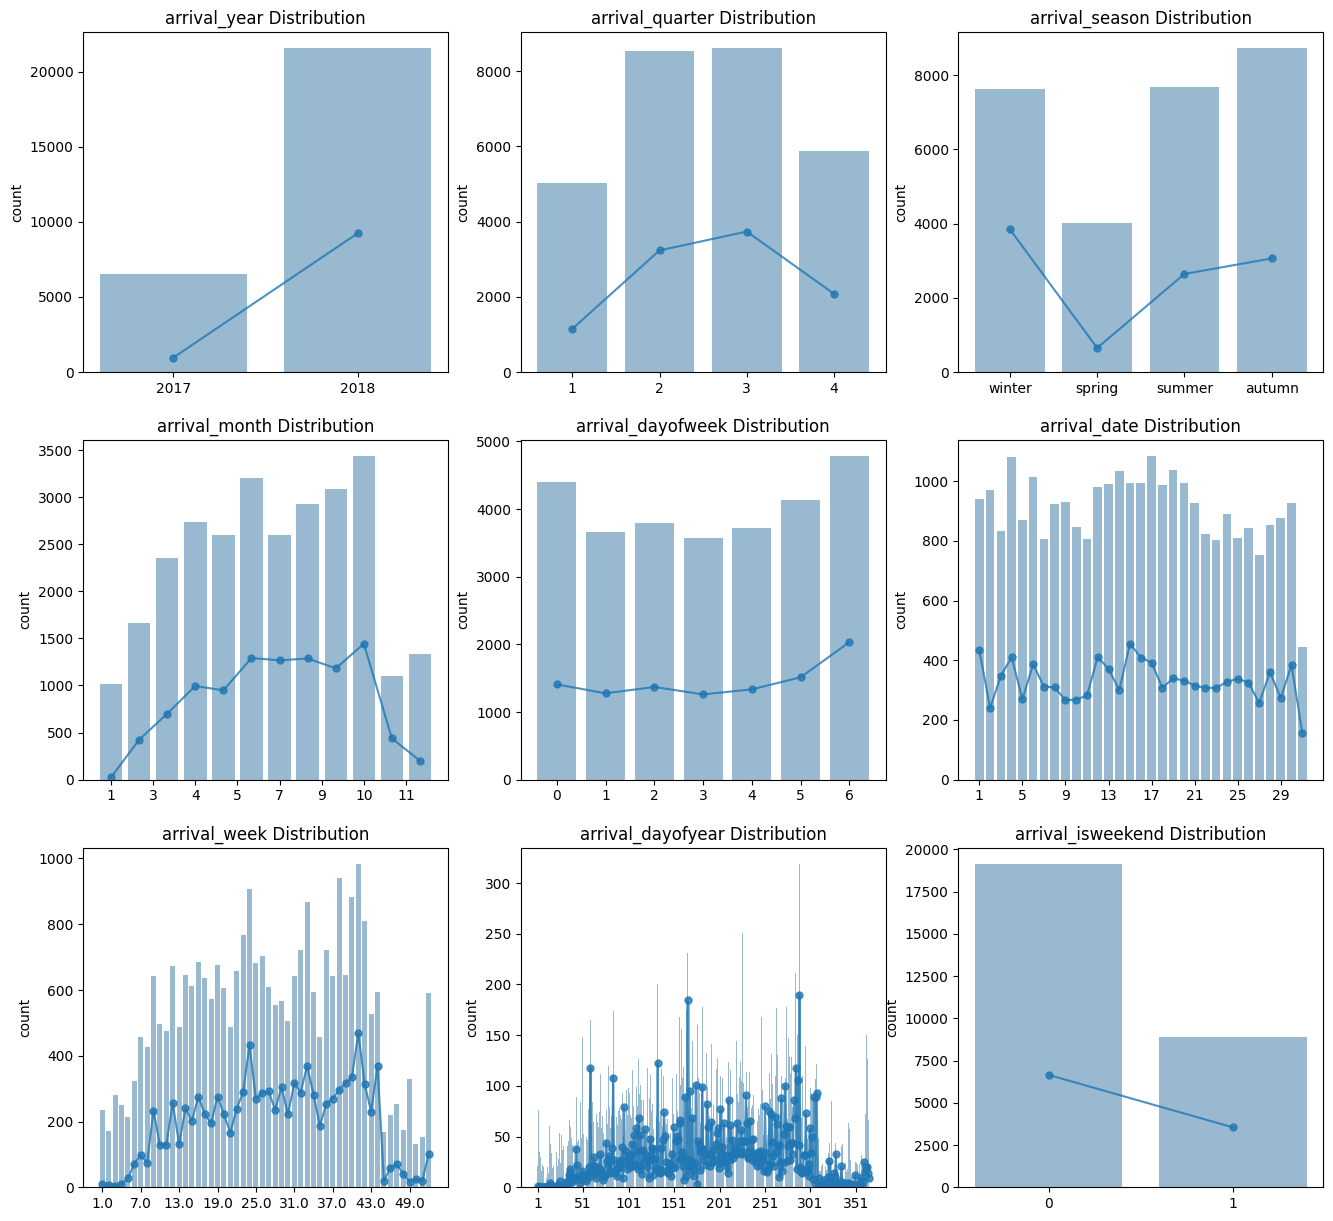

In [15]:
# visualize arrival date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(arrival_columns):
    column = arrival_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=pd.concat([X_train, y_train], axis=1), x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    

In [16]:
booking_columns = ['booking_year', 'booking_quarter', 'booking_season', 'booking_month', 'booking_dayofweek', 
           'booking_date', 'booking_week', 'booking_dayofyear', 'booking_isweekend']
n_cols = 3
n_rows = math.ceil(len(booking_columns)/n_cols)

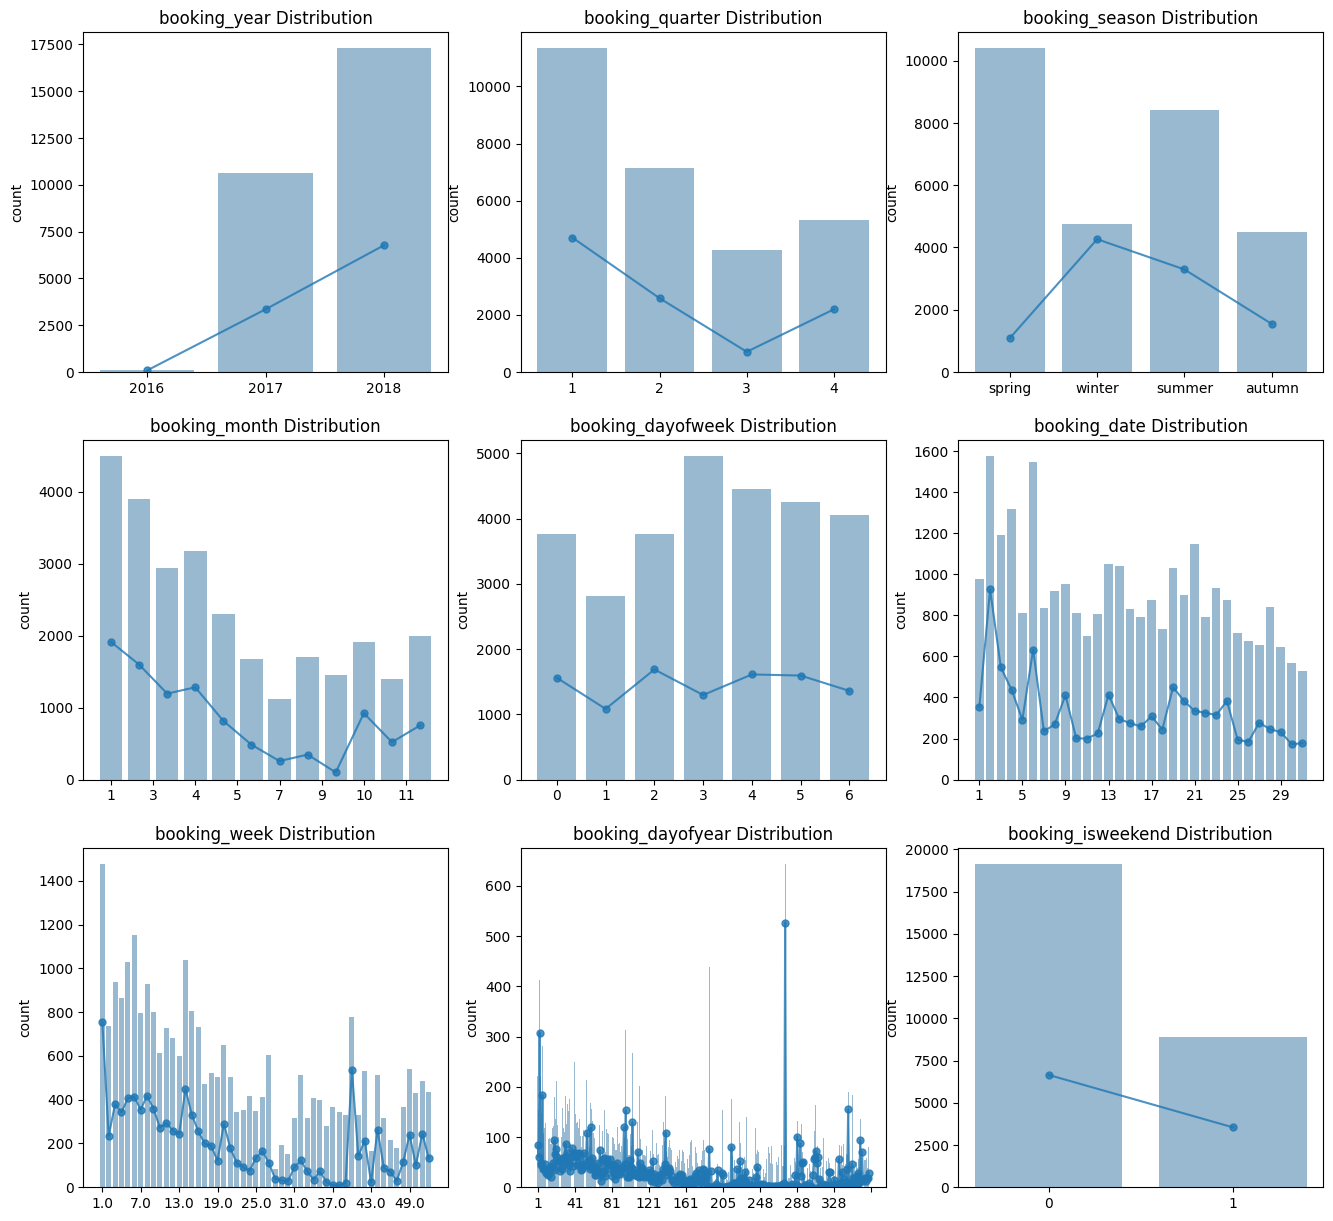

In [20]:
# visualize booking date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(booking_columns):
    column = booking_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=pd.concat([X_train, y_train], axis=1), x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

With the help of visualization, we can use the derived date columns in the following ways:
1. Arrival or Booking Year: These features should not be used, as the injected data are likely to be in later years, and the timeframe may not be long enough to capture trends over years effectively.
2. Arrival or Booking Quarter/Month/Season: While these could be useful features, two years of data may not provide sufficient information to capture seasonal patterns within a year. Therefore, we will not use them in our analysis.
3. Arrival or Booking Day of Week: This feature can be directly encoded or used to derive a binary feature indicating whether the arrival/booking occurred on a weekend.
4. Arrival or Booking Date, Week, and Day of Year: These features may not be useful due to their high cardinality and insufficient number of observations within each category. This can lead to overfitting, so we will not include them in our analysis.

## Feature Engineering on Number of Customers & Room Type

The following visualization helps us understand the relationship between number of customers and room type.

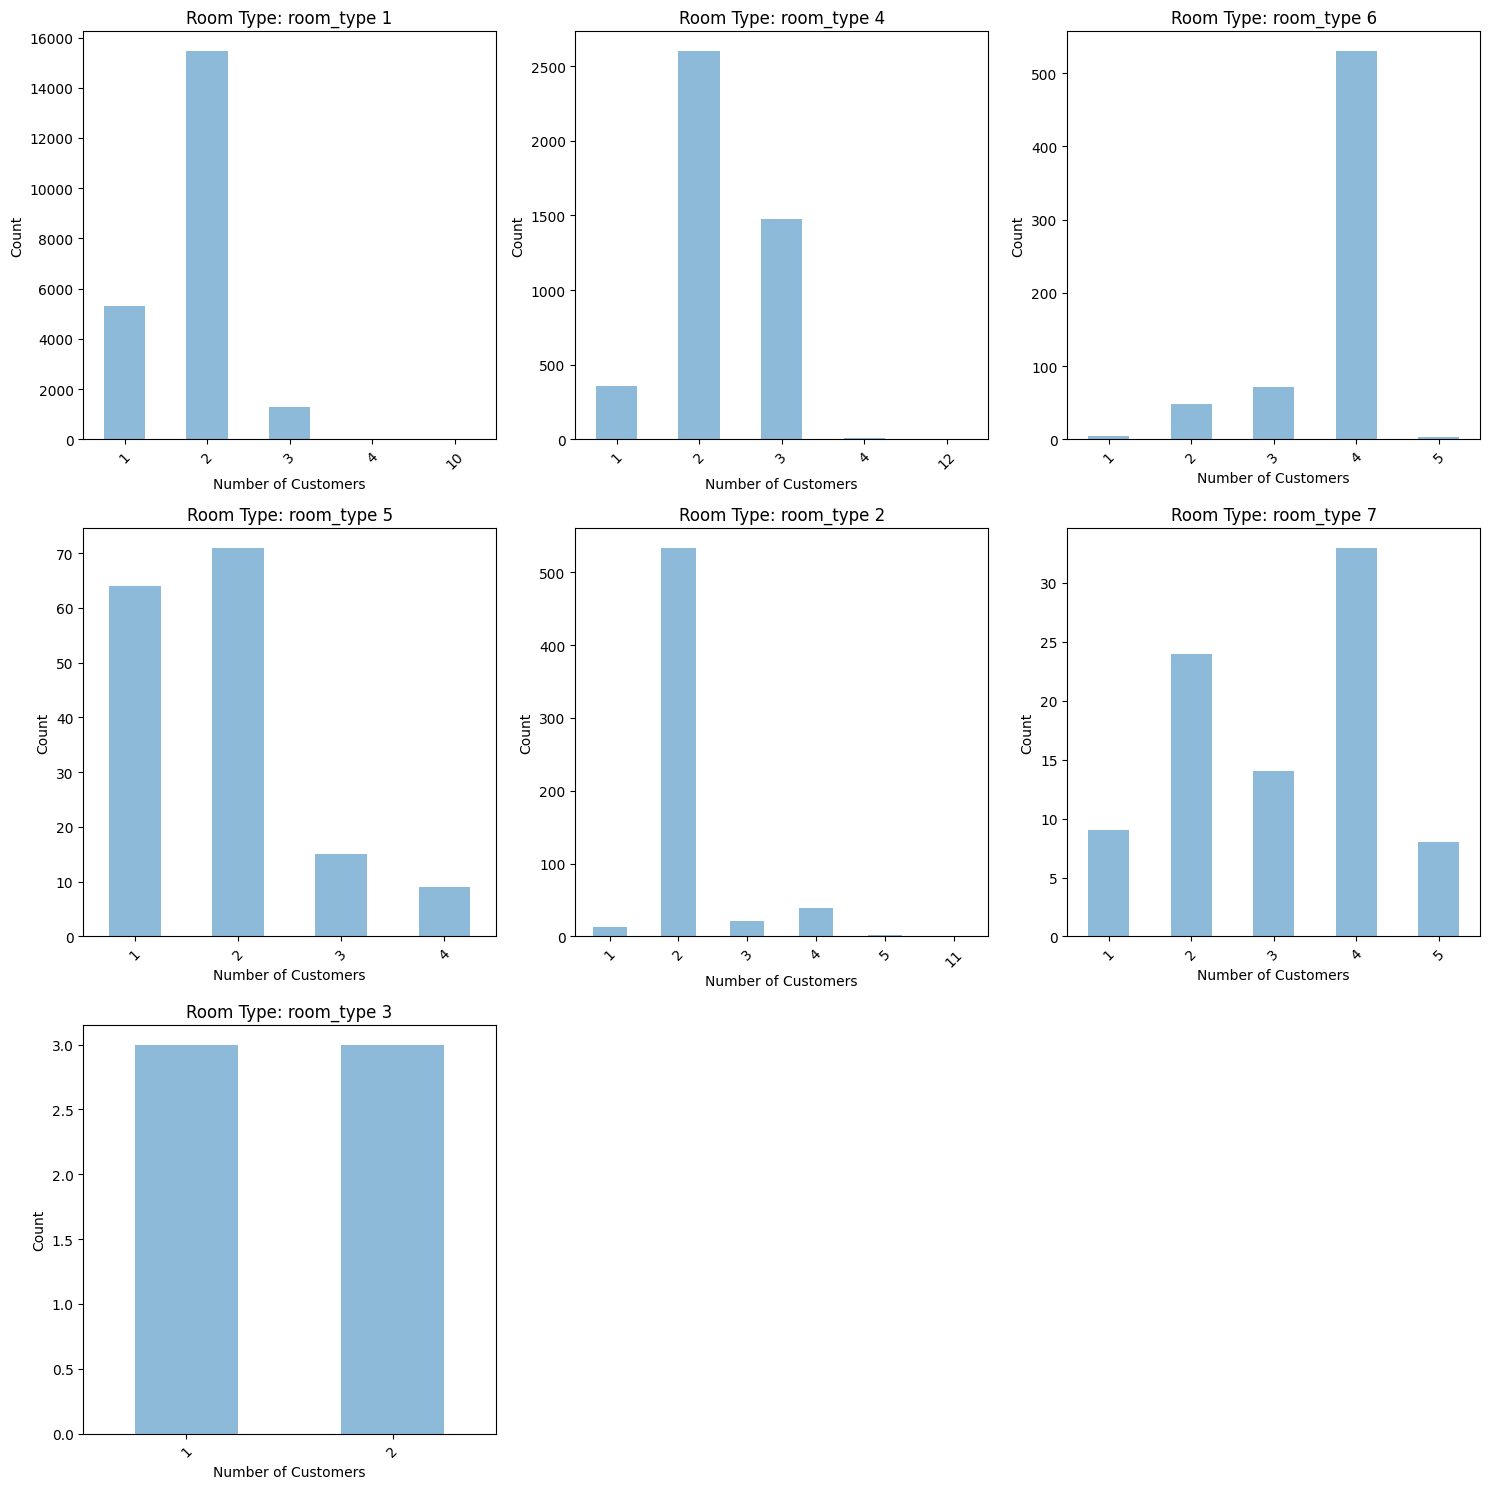

In [114]:
# Get unique values of room_type_reserved
unique_room_types = X_train['room_type_reserved'].unique()

# Determine the number of rows needed for subplot arrangement
num_rows = (len(unique_room_types) + 2) // 3  

# Plotting for each unique room type, arranged in subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
for i, room_type in enumerate(unique_room_types):
    filtered_data = X_train[X_train['room_type_reserved'] == room_type]
    count_per_customers = filtered_data['no_of_customers'].value_counts().sort_index()

    # Determine subplot position
    row = i // 3
    col = i % 3

    # Plot on the appropriate subplot
    count_per_customers.plot(kind='bar', alpha=0.5, ax=axes[row, col])
    axes[row, col].set_title(f'Room Type: {room_type}')
    axes[row, col].set_xlabel('Number of Customers')
    axes[row, col].set_ylabel('Count')
    # axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide empty subplots
for i in range(len(unique_room_types), num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

From the distribution, we observe that each type of room tends to have one or two dominant numbers of customers. This suggests that there might be a preferred or most common number of customers associated with each room type. Booking a room with a number of customers that does not align with these dominant counts could potentially lead to booking cancellations.

To address this, we introduce a new feature to identify whether the number of customers for a booking falls into a category considered rare for the corresponding room type. By identifying these rare instances, we aim to capture potential mismatches between the booked number of customers and the typical expectations for each room type.

For each room type, we define "dominant numbers of customers" as those with a count more than a threshold of 30%. The new feature, named 'num_of_customers_and_room_type_mismatch', takes a binary value indicating whether the number of customers falls into this mismatch case.

In [115]:
# Define the threshold percentage for rare numbers of customers
threshold_percentage = 0.3 
dominant_customers_dict = {}

# Calculate the threshold count for each room type
threshold_counts = {}
for room_type in unique_room_types:
    filtered_data = X_train[X_train['room_type_reserved'] == room_type]
    total_samples = len(filtered_data)
    threshold_counts[room_type] = int(total_samples * threshold_percentage)

# Create the new feature 'is_rare_customers_room_type'
X_train['num_of_customers_and_room_type_mismatch'] = 1
for room_type in unique_room_types:
    customer_counts = X_train[X_train['room_type_reserved'] == room_type]['no_of_customers'].value_counts()
    dominant_customers = customer_counts[customer_counts > threshold_counts[room_type]].index
    dominant_customers_dict[room_type] = dominant_customers
    X_train.loc[(X_train['no_of_customers'].isin(dominant_customers)) & 
                (X_train['room_type_reserved'] == room_type), 'num_of_customers_and_room_type_mismatch'] = 0

In [116]:
# Apply the stored rare customers information to X_test
X_test['num_of_customers_and_room_type_mismatch'] = 1
for room_type in unique_room_types:
    dominant_customers = dominant_customers_dict[room_type]
    X_test.loc[(X_test['no_of_customers'].isin(dominant_customers)) & 
               (X_test['room_type_reserved'] == room_type), 'num_of_customers_and_room_type_mismatch'] = 0

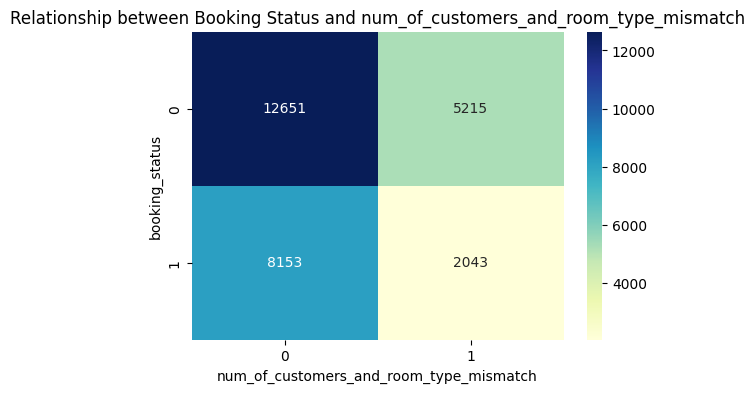

In [117]:
custom_heatmap('num_of_customers_and_room_type_mismatch')

It shows that the mismatch of room type and customer number is relevant to a lower possibility of cancellation. One potential reason is that the booking might be associated with a special occasion, such as a celebration or a solo trip, which typically entails a lower likelihood of cancellation.

## Process Newly Created Features

For these newly created features, we need to performance processing steps:
1. encode categorical variables with One-Hot Encoding
2. scale numerical variables with standardization

In [118]:
new_cat_cols = ['traveller_type', 'stay_type', 'cancellation_type', 
                'lead_time_cat', 'avg_price_per_room_cat', 
                'arrival_dayofweek', 'booking_dayofweek']
new_cat_cols_already_in_the_right_format = ['solo_traveller', 'have_special_requests', 'arrival_isweekend', 'booking_isweekend','num_of_customers_and_room_type_mismatch']

In [119]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(X_train[new_cat_cols])
X_train[enc.get_feature_names_out()] = enc.transform(X_train[new_cat_cols]).toarray()

In [120]:
# transform test data
X_test[enc.get_feature_names_out()] = enc.transform(X_test[new_cat_cols]).toarray()

In [121]:
# store the categorical column names after encoding
encoded_new_cat_cols = list(enc.get_feature_names_out())+new_cat_cols_already_in_the_right_format
encoded_new_cat_cols

['traveller_type_adults_only',
 'traveller_type_children_only',
 'traveller_type_mixed',
 'stay_type_hour_room',
 'stay_type_mixed',
 'stay_type_weekday_only',
 'stay_type_weekend_only',
 'cancellation_type_all_cancelled',
 'cancellation_type_all_successful',
 'cancellation_type_mixed',
 'cancellation_type_no_booking',
 'lead_time_cat_0 to 50',
 'lead_time_cat_100 to 150',
 'lead_time_cat_150 to 200',
 'lead_time_cat_200 to 300',
 'lead_time_cat_50 to 100',
 'lead_time_cat_greater than 300',
 'avg_price_per_room_cat_0 to 50',
 'avg_price_per_room_cat_100 to 150',
 'avg_price_per_room_cat_150 to 200',
 'avg_price_per_room_cat_200 to 300',
 'avg_price_per_room_cat_50 to 100',
 'avg_price_per_room_cat_greater than 300',
 'arrival_dayofweek_0',
 'arrival_dayofweek_1',
 'arrival_dayofweek_2',
 'arrival_dayofweek_3',
 'arrival_dayofweek_4',
 'arrival_dayofweek_5',
 'arrival_dayofweek_6',
 'booking_dayofweek_0',
 'booking_dayofweek_1',
 'booking_dayofweek_2',
 'booking_dayofweek_3',
 'booking

In [122]:
new_num_cols = ['no_of_customers', 'perc_adults', 'no_of_nights','perc_weekday_nights', 
                'no_of_previous_bookings', 'previous_cancellation_rate']

In [123]:
# fit on training data
scaler = StandardScaler()
scaler.fit(X_train[new_num_cols])
X_train[[x+'_scaled' for x in new_num_cols]] = scaler.transform(X_train[new_num_cols])

In [124]:
# transform test data
X_test[[x+'_scaled' for x in new_num_cols]] = scaler.transform(X_test[new_num_cols])

In [125]:
# store the numerical column names after scaling
scaled_new_num_cols = [x+'_scaled' for x in new_num_cols]
scaled_new_num_cols

['no_of_customers_scaled',
 'perc_adults_scaled',
 'no_of_nights_scaled',
 'perc_weekday_nights_scaled',
 'no_of_previous_bookings_scaled',
 'previous_cancellation_rate_scaled']

## Columns Dependency Examination

In [126]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()
# Remove arrival_month related features
columns = [x for x in columns if 'arrival_month' not in x]
scaled_num_cols = [x for x in columns if 'scaled' in x]
encoded_cat_cols = [x for x in columns if 'scaled' not in x]

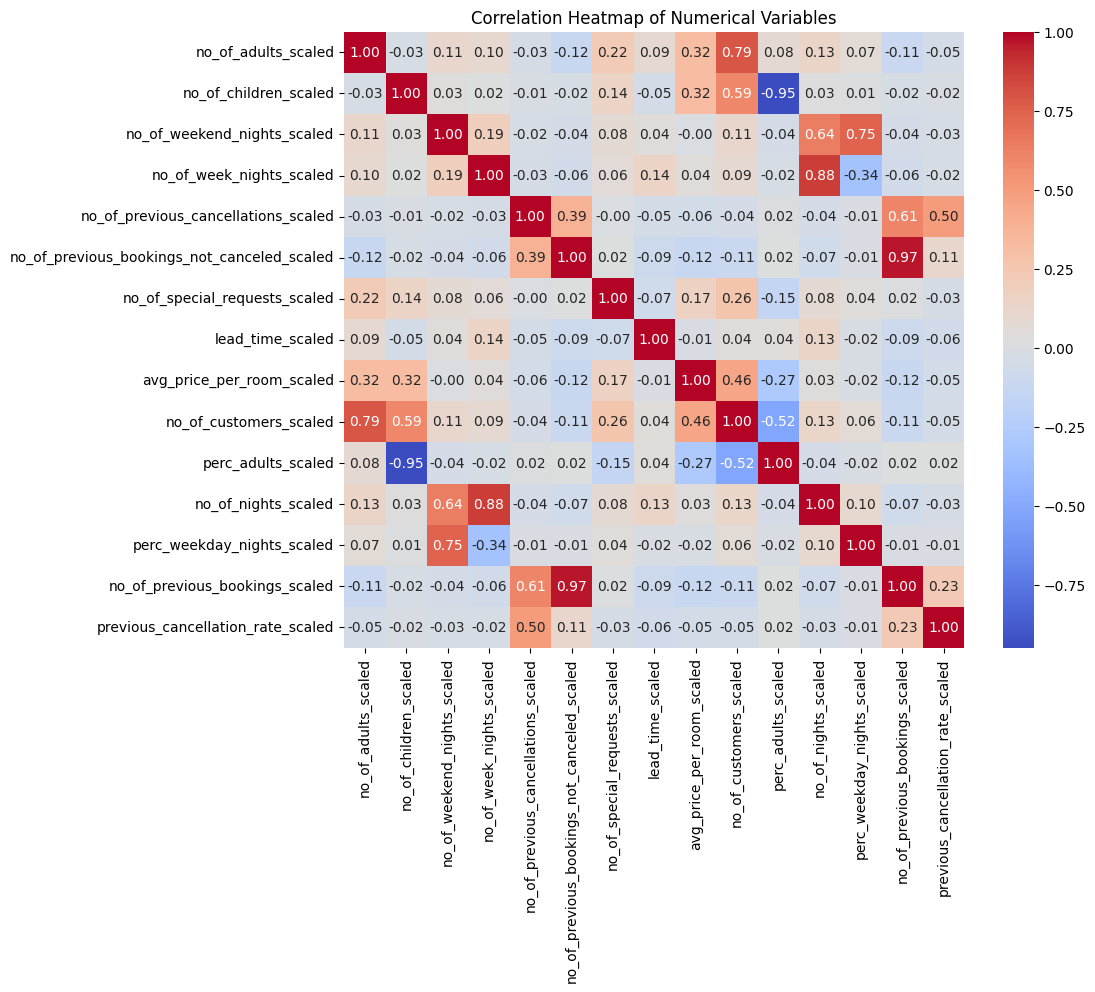

In [139]:
# test on numerical variables
plot_corrlation_heatmap(X_train[scaled_num_cols+scaled_new_num_cols])


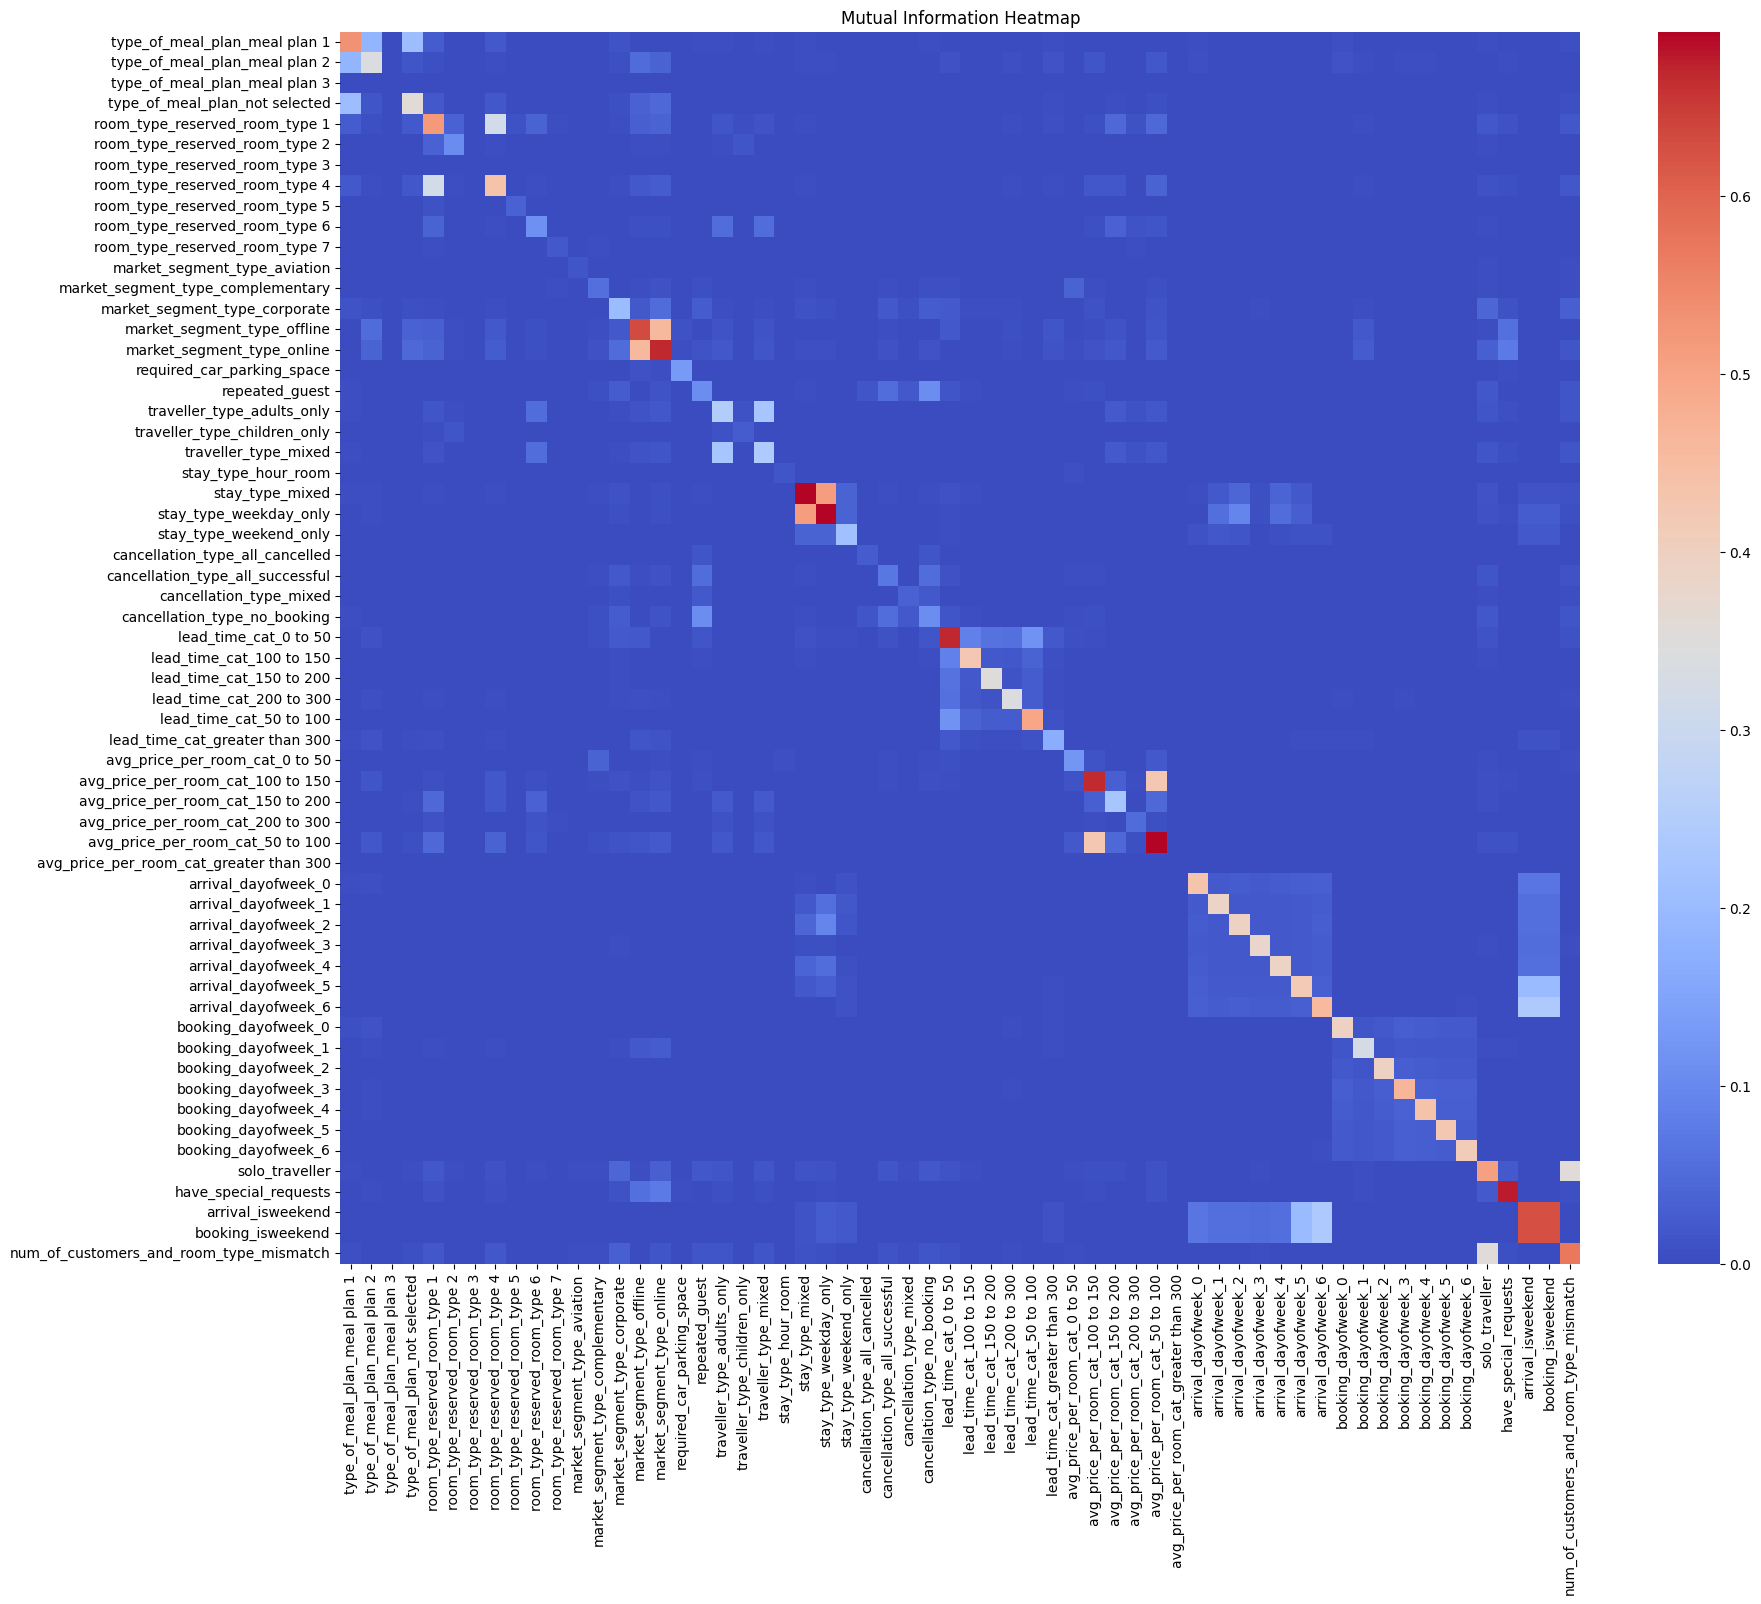

In [140]:
plot_mi_heatmap(X_train[encoded_cat_cols+encoded_new_cat_cols])

While certain columns exhibit high correlation with each other—such as 'no_of_children_scaled' and 'perc_adults_scaled', 'no_of_previous_booking_not_canceled_scaled' and 'no_of_previous_bookings_scaled', 'no_of_nights_scaled' and 'no_of_week_nights_scaled', and 'solo_traveller' and 'num_of_customers_and_room_type_mismatch'—the decision to exclude one of them depends on the amount of information each variable contributes to the model. Therefore, a more comprehensive feature selection process will be conducted alongside model training to determine the optimal set of features.

## Save the Engineered Datasets

We will now save the engineered datasets for future model building. Before that, random undersampling will be performed to resample the training data.

In [136]:
undersampler = RandomUnderSampler(random_state=47)

# Resample the training data
X_train_under_resampled, y_train_under_resampled = undersampler.fit_resample(X_train, y_train)

In [137]:
X_train_under_resampled[encoded_new_cat_cols+scaled_new_num_cols+columns].to_csv('Data/X_train_engineered.csv', index = False)
X_test[encoded_new_cat_cols+scaled_new_num_cols+columns].to_csv('Data/X_test_engineered.csv', index = False)

## Next Steps

Now, after the feature engineering stage, for the next step, we will look into trying to see if we can perform feature selection and hyperparameter tuning. This will be done for each individual model as different models that initially did not perform as well as compared to others, could turn out to be better performing after doing feature selection and hyperparameter tuning. Also, different feature selection methods apply to different models. Hence we will be applying doing feature selection + hyperparameter tuning for all the models. In addition, we will also add ensembling (bagging, boosting) models.

Next notebook to navigate to is 6.1 to 6.8.

## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb)
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb) - <b>[You Are Here Now]</b>
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb)
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb)
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)